In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
# from helpers import lorenz, rossler, rk4, sine, mackey_glass, mg_ypast, ddeint
from helpers import lorenz, rossler, rk4, sine, mackey_glass, mg_ypast
import scipy.integrate
import scipy.interpolate
from scipy.fft import fft, ifft, fftshift, fftfreq
from scipy.optimize import curve_fit
import torch

In [ ]:
'''
Generate and save target functions: Lorenz, Rossler
'''

data_dir = '/cnl/data/spate/Datasets/'
n_samples = 2
n_steps = 8000
dt = 0.01
var_names = ["x", "y", "z"]
fcn_name = "rossler"
d = 3 # Dimension of system
do_save = False
do_plot = True

if fcn_name == "lorenz":
    fcn = lorenz
    params = {'sig':10, 'rho':28, 'beta':8/3}
elif fcn_name == "rossler":
    fcn = rossler
    params = {'a':0.2, 'b':0.2, 'c':5.7}

t = np.linspace(0, n_steps * dt, num=n_steps)

sol_stack = []
for j in range(n_samples):
    y0 = np.random.uniform(size=(d,)) - 0.5

    sol = []
    y_prev = y0
    for i in range(n_steps):
        sol.append(y_prev)
        y = rk4(fcn, y_prev, dt, params)
        y_prev = y

    sol = np.stack(sol, axis=1) # (system_dimension, n_steps)
    sol_stack.append(sol)

    if do_plot:
        fig, ax = plt.subplots(1, 2, figsize=(16,8))
        ax[0].plot(sol[1], sol[2])
        ax[1].plot(sol[0], sol[1])


        ax[0].set_ylabel("z")
        ax[0].set_xlabel("y")
        ax[1].set_ylabel("y")
        ax[1].set_xlabel("x")

        fig.tight_layout()
        plt.show()


        fig, ax = plt.subplots(d, 1, figsize=(16,8), sharex=True)
        for i in range(sol.shape[0]):
            ax[i].plot(t, sol[i])
            ax[i].set_xlabel("t")
            ax[i].set_ylabel(var_names[i])
            
        fig.tight_layout()
        plt.show()

sol_stack = np.concatenate(sol_stack, axis=0) # (system_dimension * n_samples, n_steps)

params_str = ''
for k,v in params.items():
    params_str += k + f"_{v:.2f}_"

if do_save:
    np.savetxt(data_dir + f"{fcn_name}_params_{params_str}n_samples_{n_samples}_n_steps_{n_steps}_dt_{dt}.csv", sol_stack, delimiter=",")



In [ ]:
'''
Generate and save sine wave
'''
data_dir = '/cnl/data/spate/Datasets/'
n_samples = 100
n_steps = 4000
dt = 0.01
do_save = True
do_plot = True
L = 10

t = np.linspace(0, n_steps * n_samples * dt, num=n_steps * n_samples)
sol = sine(t, L)

if do_plot:
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(t, sol)
    ax.set_xlabel("t")
    ax.set_ylabel('sin(t)')
    fig.tight_layout()
    plt.show()

sol = sol.reshape(n_samples, n_steps)

if do_save:
    np.savetxt(data_dir + f"sine_period_{L}_n_samples_{n_samples}_n_steps_{n_steps}_dt_{dt}.csv", sol, delimiter=',')



[ 0.09501333 -7.44224536]


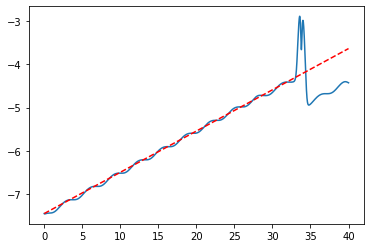

In [79]:
'''
Calculate Lyapunov exponent
'''

n_steps = 4000
dt = 0.01
var_names = ["x", "y", "z"]
fcn_name = "rossler"
d = 3 # Dimension of system
y0 = np.random.uniform(size=(d,)) - 0.5
y0_perturb = y0 + (np.random.uniform(size=(d,)) - 0.5) * 1e-3
init_conds = [y0, y0_perturb]

if fcn_name == "lorenz":
    fcn = lorenz
    params = {'sig':10, 'rho':28, 'beta':8/3}
elif fcn_name == "rossler":
    fcn = rossler
    params = {'a':0.2, 'b':0.2, 'c':5.7}

t = np.linspace(0, n_steps * dt, num=n_steps)

sols = [] # Store two solutions
for j in range(2):
    

    sol = []
    y_prev = init_conds[j]
    for i in range(n_steps):
        sol.append(y_prev)
        y = rk4(fcn, y_prev, dt, params)
        y_prev = y

    sol = np.stack(sol, axis=1)
    sols.append(sol)

log_d_t = np.log(np.sqrt(np.sum(np.square(sols[1] - sols[0]), axis=0))) # Log distance

fig, ax = plt.subplots()
ax.plot(t, log_d_t)

def lin(x, a, b):
    return a * x + b

popt_lin, _ = curve_fit(lin, t[1500:2500], log_d_t[1500:2500])

print(popt_lin)

ax.plot(t, lin(t, *popt_lin), 'r--')
plt.show()

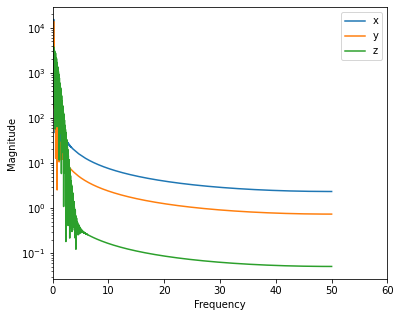

In [14]:
'''
Fourier analysis of lorenz
'''
fcn = 'rossler'
fig_dir = '/home/spate/Res/figures/'
data_dir = '/cnl/data/spate/Datasets/'
n_samples = 500
d = 3
n_steps = 8000
dt = 0.01
var_names = ["x", "y", "z"]
if fcn == 'lorenz':
    target_fn = data_dir + 'lorenz_params_sig_10.00_rho_28.00_beta_2.67_n_samples_500_n_steps_4000_dt_0.01.csv'
elif fcn == 'rossler':
    target_fn = data_dir + 'rossler_params_a_0.20_b_0.20_c_5.70_n_samples_500_n_steps_8000_dt_0.01.csv'
target_batch = np.loadtxt(target_fn, delimiter=',').reshape(n_samples, d, n_steps)
# f = np.sin(20* 2 * np.pi * t)


fig, ax = plt.subplots(figsize=(6,5))

for i in range(d):
    f = target_batch[0,i,:].reshape(-1,) # [n_samples, d, n_steps]
    f_hat = fftshift(fft(f))
    freqs = fftshift(fftfreq(n_steps, dt))

    ax.plot(freqs, np.abs(f_hat), label=var_names[i]) # Plot

ax.set_yscale('log')
ax.set_xlim(0,60)
ax.set_ylabel("Magnitude")
ax.set_xlabel("Frequency")
ax.legend()
plt.savefig(fig_dir + f"{fcn}_fourier.png")
plt.show()

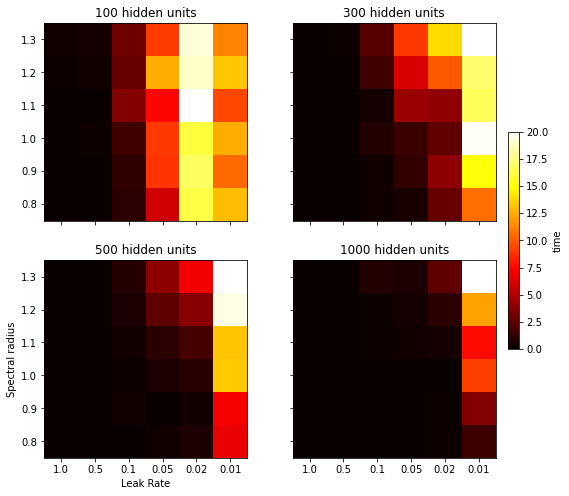

In [36]:
'''
Grid search
'''
save_dir = '/cnl/data/spate/Res/'
fig_dir = '/home/spate/Res/figures/'
n_repeats = 10
leak_rates = np.array([1, 0.5, 0.1, 0.05, 0.02, 0.01])
spectral_radii = np.array([0.8, 0.9, 1.0, 1.1, 1.2, 1.3])
n_params = np.arange(6)
n_hiddens = np.array([100, 300, 500, 1000])
last_t_min = 0
last_t_max = 20
fcn = 'mackey_glass'
do_save = True


fig, ax = plt.subplots(2, 2, figsize=(9,8), sharey=True, sharex=True, gridspec_kw={"width_ratios":[4/5, 1]})

for i, n in enumerate(n_hiddens):

    # Load data
    fn = save_dir + f"{fcn}_grid_search_spectral_radius_leak_rate_hidden_units_{n}.csv"
    last_t = np.loadtxt(fn, delimiter=',').reshape(spectral_radii.shape[0], leak_rates.shape[0], n_repeats)
    last_t = last_t.mean(axis=-1)

    ax[i // 2, i % 2].pcolormesh(n_params, n_params, last_t, cmap='hot') # Plot

    # Label plot
    ax[i // 2, i % 2].set_title(f"{n} hidden units")
    ax[-1, 0].set_ylabel("Spectral radius")
    ax[-1, 0].set_xlabel("Leak Rate")
    ax[-1, -1].set_xticks(n_params)
    ax[-1, -1].set_yticks(n_params)
    ax[-1, -1].set_xticklabels(leak_rates)
    ax[-1, -1].set_yticklabels(spectral_radii)

cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=last_t_min, vmax=last_t_max)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='time', ax=ax[:,-1], shrink=0.5)

if do_save:
    plt.savefig(fig_dir + f"{fcn}_grid_search_heatmap_last_t_mean.png")

plt.show()

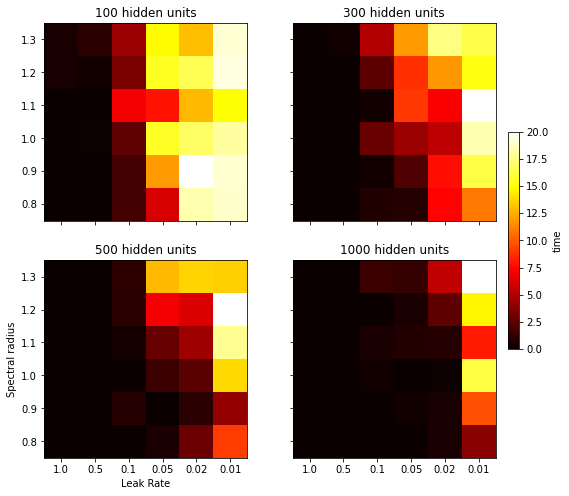

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(9,8), sharey=True, sharex=True, gridspec_kw={"width_ratios":[4/5, 1]})

for i, n in enumerate(n_hiddens):

    # Load data
    fn = save_dir + f"{fcn}_grid_search_spectral_radius_leak_rate_hidden_units_{n}.csv"
    last_t = np.loadtxt(fn, delimiter=',').reshape(spectral_radii.shape[0], leak_rates.shape[0], n_repeats)
    last_t = np.std(last_t, axis=-1)

    ax[i // 2, i % 2].pcolormesh(n_params, n_params, last_t, cmap='hot') # Plot

    # Label plot
    ax[i // 2, i % 2].set_title(f"{n} hidden units")
    ax[-1, 0].set_ylabel("Spectral radius")
    ax[-1, 0].set_xlabel("Leak Rate")
    ax[-1, -1].set_xticks(n_params)
    ax[-1, -1].set_yticks(n_params)
    ax[-1, -1].set_xticklabels(leak_rates)
    ax[-1, -1].set_yticklabels(spectral_radii)

cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=last_t_min, vmax=last_t_max)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='time', ax=ax[:,-1], shrink=0.5)

if do_save:
    plt.savefig(fig_dir + f"{fcn}_grid_search_heatmap_last_t_std.png")

plt.show()

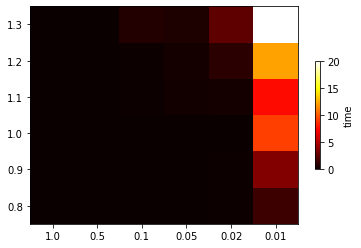

In [28]:
leak_rates = np.array([1, 0.5, 0.1, 0.05, 0.02, 0.01])
spectral_radii = np.array([0.8, 0.9, 1.0, 1.1, 1.2, 1.3])
n_repeats = 10
n_params = np.arange(6)

foo  = np.loadtxt('/cnl/data/spate/Res/mackey_glass_grid_search_spectral_radius_leak_rate_hidden_units_1000.csv', delimiter=',')
foo = foo.reshape(spectral_radii.shape[0], leak_rates.shape[0], n_repeats).mean(axis=-1)
fig, ax = plt.subplots()

ax.pcolormesh(n_params, n_params, foo, cmap='hot')

ax.set_xticks(n_params)
ax.set_yticks(n_params)
ax.set_xticklabels(leak_rates)
ax.set_yticklabels(spectral_radii)

cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=0, vmax=20)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='time', ax=ax, shrink=0.5)
plt.show()

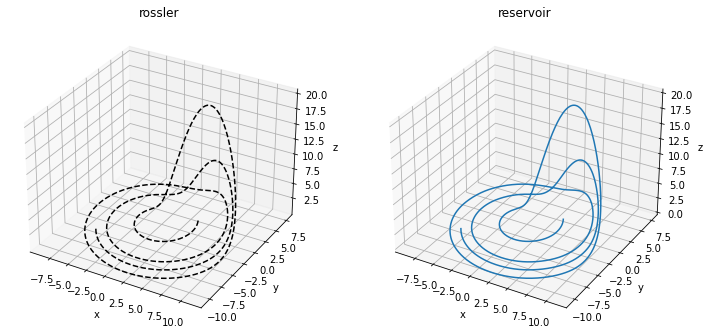

In [21]:
test_sample = 495
dt = 0.01 # For simulation of target system
end_forcing = 4000
fcn = 'rossler'
fig_dir = '/home/spate/Res/figures/'
data_dir = '/cnl/data/spate/Datasets/'
fn_output = f"{fcn}_prediction_outputs_test_sample_{test_sample}.csv"
fn_target = f"{fcn}_prediction_target_test_sample_{test_sample}.csv"
if fcn == 'lorenz':
    target_fn = data_dir + 'lorenz_params_sig_10.00_rho_28.00_beta_2.67_n_samples_500_n_steps_4000_dt_0.01.csv'
elif fcn == 'rossler':
    target_fn = data_dir + 'rossler_params_a_0.20_b_0.20_c_5.70_n_samples_500_n_steps_8000_dt_0.01.csv'
total_steps = 8000
d = 3
total_samples = 500
n_outputs = 3
do_scl = True

target_lib = np.loadtxt(target_fn, delimiter=',').reshape(total_samples, d, total_steps)
flat_target = np.transpose(target_lib, axes=[1, 0, 2]).reshape(n_outputs, -1)
target_mean, target_std = np.mean(flat_target, axis=1).reshape(3,1), np.std(flat_target, axis=1).reshape(3,1)

target = np.loadtxt(data_dir + fn_target, delimiter=',')[:, end_forcing:]
output = np.loadtxt(data_dir + fn_output, delimiter=',')[:, end_forcing:]

if do_scl:
    target = (target * target_std) + target_mean
    output = (output * target_std) + target_mean

fig = plt.figure(figsize=(12,9))

ax0 = fig.add_subplot(1, 2, 1, projection="3d")
ax1 = fig.add_subplot(1, 2, 2, projection="3d")


ax0.plot(target[0,:], target[1,:], target[2,:], 'k--')
ax1.plot(output[0,:], output[1,:], output[2,:])

ax0.set_title(f"{fcn}")
ax1.set_title("reservoir")
ax0.set_xlabel("x")
ax0.set_ylabel('y')
ax0.set_zlabel('z')
ax1.set_xlabel("x")
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# ax0.view_init(azim=90, elev=10)
# fig.tight_layout()
plt.savefig(fig_dir + f"{fcn}_attractor_v_reservoir_test_sample_{test_sample}.png")
plt.show()

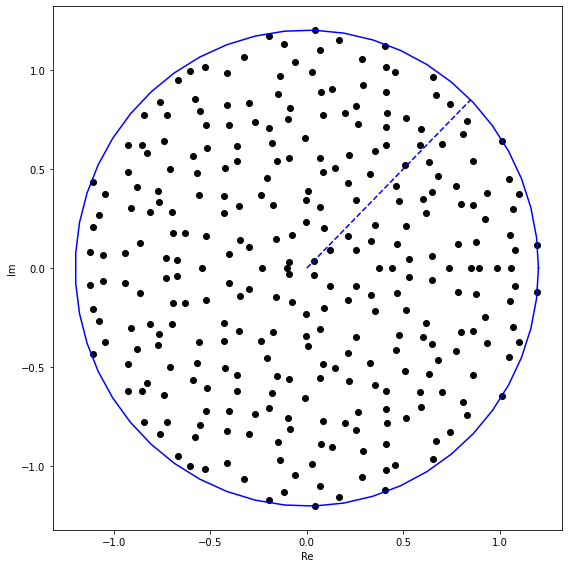

In [49]:
'''
Illustrative graph spectrum
'''

fig_dir = '/home/spate/Res/figures/'
desired_sr = 1.2
w = np.random.uniform(-1, 1, size=(300, 300))
evals, _ = np.linalg.eig(w)
sr = np.abs(evals).max()
scl_w = w * (desired_sr / sr)
evals, _ = np.linalg.eig(scl_w)
new_sr = np.abs(evals).max()
theta = np.linspace(0, 2 * np.pi)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.real(evals), np.imag(evals), 'ko')
ax.plot(new_sr * np.cos(theta), new_sr * np.sin(theta), 'b-')
ax.plot([0, new_sr * np.cos(np.pi / 4)], [0, new_sr * np.sin(np.pi / 4)], 'b--')

ax.set_ylabel("Im")
ax.set_xlabel("Re")

fig.tight_layout()
plt.savefig(fig_dir + "illustrative_graph_spectrum.png")
plt.show()